## 1. Setup & Imports

In [1]:
import sys
sys.path.append('../src')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Import custom modules
from preprocessing import (
    preprocess_dataframe,
    create_tfidf_features,
    encode_labels,
    save_preprocessors
)
from train import (
    train_logistic_regression,
    train_linear_svm,
    train_random_forest,
    save_model
)
from evaluate import (
    evaluate_model,
    plot_confusion_matrix,
    analyze_misclassifications,
    compare_models
)

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')

## 2. Load Data

In [2]:
# Load datasets
train_df = pd.read_csv('../data/train.csv')
val_df = pd.read_csv('../data/val.csv')

print(f"Training samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")
print(f"\nCategories: {train_df['categories'].unique().tolist()}")
print(f"\nSample data:")
train_df.head()

Training samples: 8936
Validation samples: 2681

Categories: ['houseorplot', 'flat', 'landparcel', 'others', 'commercial unit']

Sample data:


,property_address,categories
0,"New Ppid 1Kqttmg7, House, Property Id No.58C57...",houseorplot
1,"Property Of Rs No.12/2,Plot No. 01,House Numbe...",houseorplot
2,"Flat-504,Floor-5 Shanti Vista-Ii Wing C Bldg 9...",flat
3,"Flat-103,Floor-1 Eshamya Florenza Tower L S No...",flat
4,Flat No G 532 I P Extension Patparganj 2Nd Flo...,flat


## 3. Text Preprocessing

**Steps**:
- Convert to lowercase
- Remove special characters (keep numbers - they're important for addresses!)
- Remove extra whitespace

In [3]:
# Preprocess text
train_df = preprocess_dataframe(train_df, text_column='property_address')
val_df = preprocess_dataframe(val_df, text_column='property_address')

# Show before and after
print("Text Preprocessing Examples:")
print("=" * 80)
for i in range(5):
    print(f"\nOriginal: {train_df.iloc[i]['property_address']}")
    print(f"Cleaned:  {train_df.iloc[i]['clean_address']}")

Text Preprocessing Examples:

Original: New Ppid 1Kqttmg7, House, Property Id No.58C57U54 Having Land Measuring 200 Sq.Yd Situated At Vaka Jasico Colony, Jagadhri, And Distt. Yamunanagar Inside Mc Limits, Tehsil Jagadhri Near Mandir
Cleaned:  new ppid 1kqttmg7 house property id no 58c57u54 having land measuring 200 sq yd situated at vaka jasico colony jagadhri and distt yamunanagar inside mc limits tehsil jagadhri near mandir

Original: Property Of Rs No.12/2,Plot No. 01,House Number.7/48 & 5/13, E-Swatthu 
 No:151500500900500801, Situated At Kotnoor(D) Village, Kalaburagi 
 Taluk, Dist.Kalaburagi . 585102.
Cleaned:  property of rs no 12 2 plot no 01 house number 7 48 5 13 e swatthu no 151500500900500801 situated at kotnoor d village kalaburagi taluk dist kalaburagi 585102

Original: Flat-504,Floor-5 Shanti Vista-Ii Wing C Bldg 9 S No 52 & 54,Wing C,Offvillage Khaira ,Yashwantshrusthi Boisar-Palghar Road,Boisar West Palghar 401501 Maharashtra
Cleaned:  flat 504 floor 5 shanti vista ii 

## 4. Feature Extraction - TF-IDF

**Why TF-IDF?**
- Excellent for text classification tasks
- Captures important keywords in addresses
- Handles variable-length text well
- Works great with linear models

**Parameters**:
- `ngram_range=(1,2)`: Capture unigrams and bigrams (e.g., "flat", "plot no")
- `min_df=2`: Ignore very rare terms
- `max_features=5000`: Limit feature space

In [4]:
# Create TF-IDF features
X_train, X_val, _, vectorizer = create_tfidf_features(
    train_df['clean_address'],
    val_df['clean_address'],
    ngram_range=(1, 2),
    min_df=2,
    max_features=5000
)

print("TF-IDF Feature Extraction:")
print("=" * 80)
print(f"Training features shape: {X_train.shape}")
print(f"Validation features shape: {X_val.shape}")
print(f"Number of features: {X_train.shape[1]}")
print(f"Feature sparsity: {(1 - X_train.nnz / (X_train.shape[0] * X_train.shape[1])) * 100:.2f}%")

TF-IDF Feature Extraction:
Training features shape: (8936, 5000)
Validation features shape: (2681, 5000)
Number of features: 5000
Feature sparsity: 99.58%


In [5]:
# Show top features
feature_names = vectorizer.get_feature_names_out()
print("\nSample features (first 50):")
print(feature_names[:50])


Sample features (first 50):
['00' '00 sq' '001' '00h' '01' '01 sector' '02' '03' '04' '04th'
 '04th floor' '05' '06' '07' '08' '09' '10' '10 11' '10 situated' '100'
 '1001' '1002' '1003' '1004' '101' '101 floor' '102' '102 floor' '103'
 '103 floor' '104' '104 floor' '105' '106' '107' '108' '109' '10th'
 '10th floor' '11' '11 12' '11 sq' '110' '110015' '110059' '110084'
 '110085' '1101' '1103' '1104']


## 5. Label Encoding

In [6]:
# Encode labels
y_train, y_val, _, label_encoder = encode_labels(
    train_df['categories'],
    val_df['categories']
)

print("Label Encoding:")
print("=" * 80)
print(f"Classes: {label_encoder.classes_}")
print(f"Number of classes: {len(label_encoder.classes_)}")
print(f"\nEncoding mapping:")
for idx, label in enumerate(label_encoder.classes_):
    print(f"  {label:20s} → {idx}")

Label Encoding:
Classes: ['commercial unit' 'flat' 'houseorplot' 'landparcel' 'others']
Number of classes: 5

Encoding mapping:
  commercial unit      → 0
  flat                 → 1
  houseorplot          → 2
  landparcel           → 3
  others               → 4


## 6. Model Training

We'll train multiple models and compare their performance:
1. **Logistic Regression** (baseline)
2. **Linear SVM** 
3. **Random Forest** (optional)

All models use `class_weight='balanced'` to handle class imbalance.

### 6.1 Logistic Regression (Baseline)

In [7]:
print("Training Logistic Regression...")
lr_model = train_logistic_regression(X_train, y_train, class_weight='balanced')

# Training and validation accuracy
train_acc_lr = lr_model.score(X_train, y_train)
val_acc_lr = lr_model.score(X_val, y_val)

print(f"\nLogistic Regression Results:")
print(f"  Training accuracy:   {train_acc_lr:.4f}")
print(f"  Validation accuracy: {val_acc_lr:.4f}")

Training Logistic Regression...

Logistic Regression Results:
  Training accuracy:   0.9276
  Validation accuracy: 0.8695


### 6.2 Linear SVM

In [8]:
print("Training Linear SVM...")
svm_model = train_linear_svm(X_train, y_train, class_weight='balanced')

# Training and validation accuracy
train_acc_svm = svm_model.score(X_train, y_train)
val_acc_svm = svm_model.score(X_val, y_val)

print(f"\nLinear SVM Results:")
print(f"  Training accuracy:   {train_acc_svm:.4f}")
print(f"  Validation accuracy: {val_acc_svm:.4f}")

Training Linear SVM...

Linear SVM Results:
  Training accuracy:   0.9879
  Validation accuracy: 0.8903


### 6.3 Random Forest (Optional)

In [9]:
print("Training Random Forest...")
rf_model = train_random_forest(X_train, y_train, class_weight='balanced')

# Training and validation accuracy
train_acc_rf = rf_model.score(X_train, y_train)
val_acc_rf = rf_model.score(X_val, y_val)

print(f"\nRandom Forest Results:")
print(f"  Training accuracy:   {train_acc_rf:.4f}")
print(f"  Validation accuracy: {val_acc_rf:.4f}")

Training Random Forest...

Random Forest Results:
  Training accuracy:   0.8789
  Validation accuracy: 0.8370


## 7. Model Comparison

In [10]:
# Compare all models
models_dict = {
    'Logistic Regression': lr_model,
    'Linear SVM': svm_model,
    'Random Forest': rf_model
}

comparison_df = compare_models(models_dict, X_val, y_val, label_encoder)

MODEL COMPARISON
              Model  Accuracy  Macro F1  Macro Precision  Macro Recall
         Linear SVM  0.890339  0.873573         0.869253      0.878796
Logistic Regression  0.869452  0.855128         0.845471      0.870511
      Random Forest  0.837001  0.827744         0.838932      0.844514


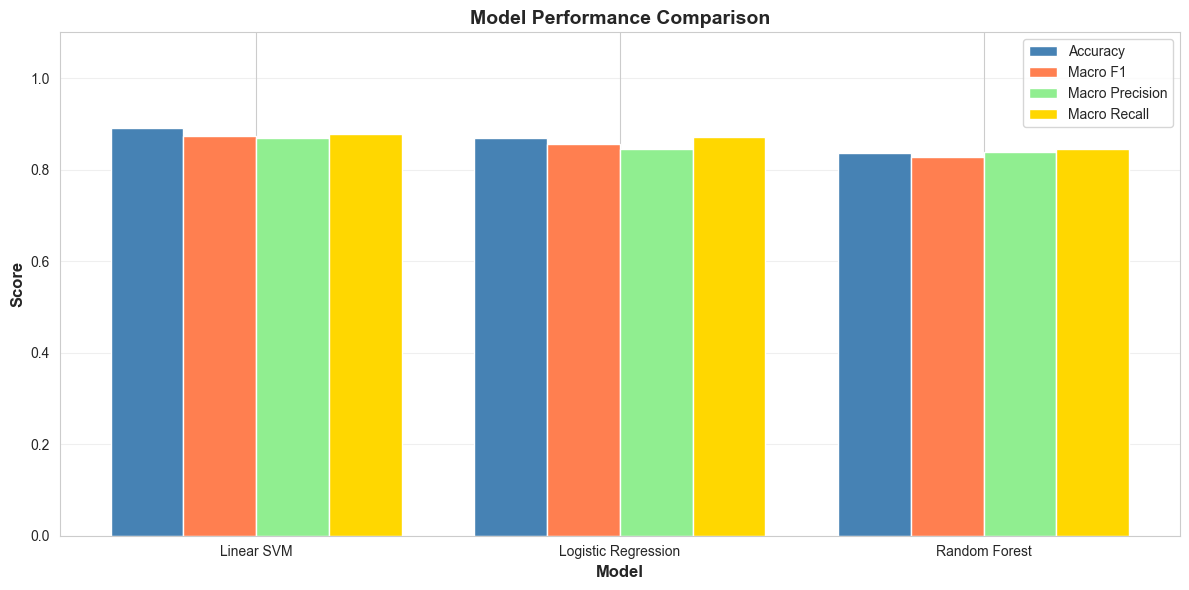

In [11]:
# Visualize comparison
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(comparison_df))
width = 0.2

ax.bar(x - 1.5*width, comparison_df['Accuracy'], width, label='Accuracy', color='steelblue')
ax.bar(x - 0.5*width, comparison_df['Macro F1'], width, label='Macro F1', color='coral')
ax.bar(x + 0.5*width, comparison_df['Macro Precision'], width, label='Macro Precision', color='lightgreen')
ax.bar(x + 1.5*width, comparison_df['Macro Recall'], width, label='Macro Recall', color='gold')

ax.set_xlabel('Model', fontweight='bold', fontsize=12)
ax.set_ylabel('Score', fontweight='bold', fontsize=12)
ax.set_title('Model Performance Comparison', fontweight='bold', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(comparison_df['Model'])
ax.legend()
ax.set_ylim(0, 1.1)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## 8. Detailed Evaluation - Best Model

Select the best model based on **Macro F1 Score** and perform detailed evaluation.

In [12]:
# Select best model (highest Macro F1)
best_model_name = comparison_df.iloc[0]['Model']
best_model = models_dict[best_model_name]

print(f"Best Model: {best_model_name}")
print("=" * 80)

Best Model: Linear SVM


### 8.1 Classification Report

In [13]:
# Evaluate on validation set
results = evaluate_model(
    best_model,
    X_val,
    y_val,
    label_encoder,
    print_report=True
)

CLASSIFICATION REPORT
                 precision    recall  f1-score   support

commercial unit     0.9576    0.9345    0.9459       290
           flat     0.9584    0.9268    0.9423       970
    houseorplot     0.8833    0.8778    0.8806       802
     landparcel     0.7717    0.8192    0.7948       260
         others     0.7752    0.8357    0.8043       359

       accuracy                         0.8903      2681
      macro avg     0.8693    0.8788    0.8736      2681
   weighted avg     0.8932    0.8903    0.8914      2681


OVERALL METRICS
Accuracy:          0.8903
Macro F1 Score:    0.8736
Macro Precision:   0.8693
Macro Recall:      0.8788


### 8.2 Confusion Matrix

Confusion matrix saved to ../best_model/confusion_matrix.png


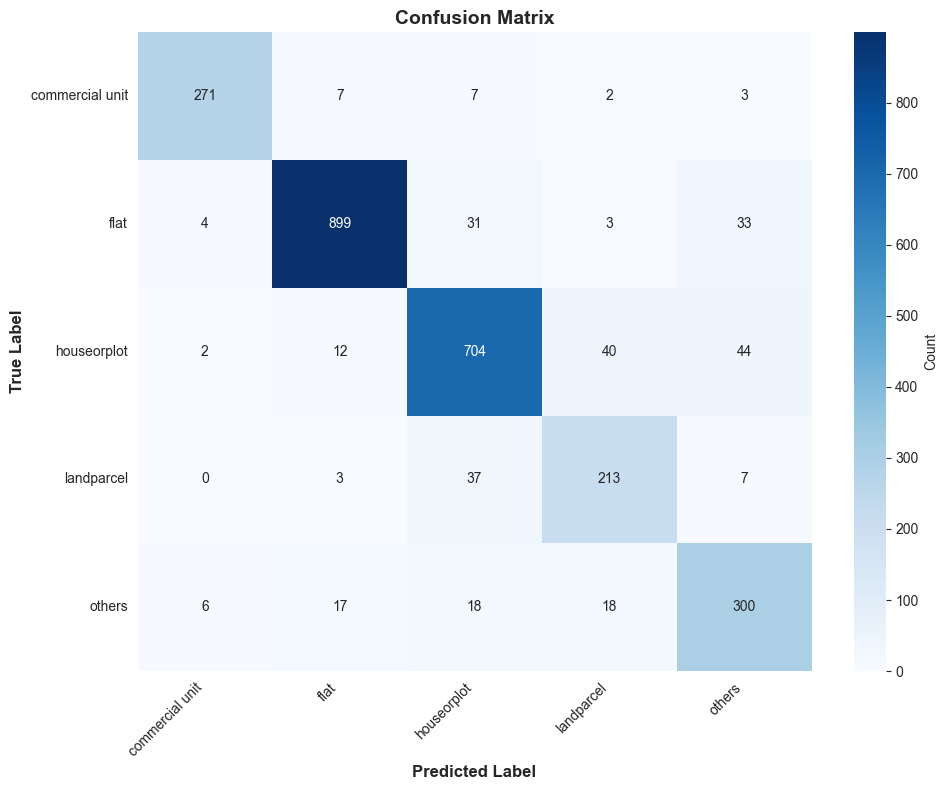

In [14]:
# Plot confusion matrix
cm = plot_confusion_matrix(
    y_val,
    results['y_pred'],
    label_encoder,
    save_path='../best_model/confusion_matrix.png'
)

### 8.3 Misclassification Analysis

In [15]:
# Analyze misclassifications
misclassified_df = analyze_misclassifications(
    val_df,
    y_val,
    results['y_pred'],
    label_encoder,
    top_n=5
)

if misclassified_df is not None:
    print("\nSample Misclassifications:")
    print("=" * 80)
    display_cols = ['property_address', 'true_label', 'pred_label']
    print(misclassified_df[display_cols].head(10).to_string(index=False))

MISCLASSIFICATION ANALYSIS

Total misclassified: 294 / 2681
Misclassification rate: 10.97%

Most common confusion pairs:
--------------------------------------------------------------------------------
houseorplot          → others               :   44 cases
houseorplot          → landparcel           :   40 cases
landparcel           → houseorplot          :   37 cases
flat                 → others               :   33 cases
flat                 → houseorplot          :   31 cases
others               → landparcel           :   18 cases
others               → houseorplot          :   18 cases
others               → flat                 :   17 cases
houseorplot          → flat                 :   12 cases
commercial unit      → flat                 :    7 cases

Sample Misclassifications:
                                                                                                                                   property_address  true_label  pred_label
                            

## 9. Feature Importance Analysis

For Logistic Regression, we can examine which features (words/bigrams) are most important for each category.

In [16]:
if best_model_name == 'Logistic Regression':
    # Get feature importance from coefficients
    feature_names = vectorizer.get_feature_names_out()
    
    print("Top 10 Important Features per Category:")
    print("=" * 80)
    
    for idx, category in enumerate(label_encoder.classes_):
        coefficients = best_model.coef_[idx]
        top_indices = np.argsort(coefficients)[-10:][::-1]
        top_features = [(feature_names[i], coefficients[i]) for i in top_indices]
        
        print(f"\n{category.upper()}:")
        for feature, coef in top_features:
            print(f"  {feature:30s}: {coef:8.4f}")
else:
    print("Feature importance analysis available only for Logistic Regression")

Feature importance analysis available only for Logistic Regression


## 10. Save Final Model & Preprocessors

In [17]:
# Save the best model
save_model(best_model, 'best_model', save_dir='../best_model')

# Save preprocessors
save_preprocessors(vectorizer, label_encoder, save_dir='../best_model')

print("\n" + "=" * 80)
print("✓ Model and preprocessors saved successfully!")
print("=" * 80)

Model saved to ../best_model/best_model.pkl
Preprocessors saved to ../best_model/

✓ Model and preprocessors saved successfully!


## 11. Final Summary & Insights

In [18]:
print("="*80)
print("FINAL MODEL SUMMARY")
print("="*80)

print(f"\n1. BEST MODEL: {best_model_name}")

print("\n2. KEY METRICS:")
print(f"   - Accuracy:         {results['accuracy']:.4f}")
print(f"   - Macro F1 Score:   {results['macro_f1']:.4f} ⭐")
print(f"   - Macro Precision:  {results['macro_precision']:.4f}")
print(f"   - Macro Recall:     {results['macro_recall']:.4f}")

print("\n3. APPROACH:")
print("   - Text preprocessing: lowercase, remove special chars, keep numbers")
print("   - Feature extraction: TF-IDF (1-2 grams, max 5000 features)")
print(f"   - Model: {best_model_name} with class_weight='balanced'")

print("\n4. MODEL FILES SAVED:")
print("   - ../best_model/best_model.pkl")
print("   - ../best_model/tfidf_vectorizer.pkl")
print("   - ../best_model/label_encoder.pkl")
print("   - ../best_model/confusion_matrix.png")

print("\n5. REPRODUCIBILITY:")
print("   ✓ All preprocessing steps documented")
print("   ✓ Model parameters saved")
print("   ✓ Random seeds set (random_state=42)")
print("   ✓ Full evaluation metrics reported")

print("\n6. NEXT STEPS FOR PRODUCTION:")
print("   - Load saved models using joblib.load()")
print("   - Preprocess new addresses using same pipeline")
print("   - Transform with saved vectorizer")
print("   - Predict using best_model")
print("   - Decode predictions using label_encoder")

print("\n" + "="*80)
print("PROJECT COMPLETED SUCCESSFULLY ✓")
print("="*80)

FINAL MODEL SUMMARY

1. BEST MODEL: Linear SVM

2. KEY METRICS:
   - Accuracy:         0.8903
   - Macro F1 Score:   0.8736 ⭐
   - Macro Precision:  0.8693
   - Macro Recall:     0.8788

3. APPROACH:
   - Text preprocessing: lowercase, remove special chars, keep numbers
   - Feature extraction: TF-IDF (1-2 grams, max 5000 features)
   - Model: Linear SVM with class_weight='balanced'

4. MODEL FILES SAVED:
   - ../best_model/best_model.pkl
   - ../best_model/tfidf_vectorizer.pkl
   - ../best_model/label_encoder.pkl
   - ../best_model/confusion_matrix.png

5. REPRODUCIBILITY:
   ✓ All preprocessing steps documented
   ✓ Model parameters saved
   ✓ Random seeds set (random_state=42)
   ✓ Full evaluation metrics reported

6. NEXT STEPS FOR PRODUCTION:
   - Load saved models using joblib.load()
   - Preprocess new addresses using same pipeline
   - Transform with saved vectorizer
   - Predict using best_model
   - Decode predictions using label_encoder

PROJECT COMPLETED SUCCESSFULLY ✓


## 12. Example: Making Predictions on New Data

In [19]:
# Example prediction function
def predict_address_category(address, model, vectorizer, label_encoder):
    """
    Predict category for a new address.
    
    Args:
        address: Raw address string
        model: Trained classifier
        vectorizer: Fitted TF-IDF vectorizer
        label_encoder: Fitted label encoder
        
    Returns:
        str: Predicted category
    """
    # Import preprocessing function
    from preprocessing import clean_text
    
    # Preprocess
    cleaned = clean_text(address)
    
    # Vectorize
    features = vectorizer.transform([cleaned])
    
    # Predict
    prediction = model.predict(features)[0]
    
    # Decode
    category = label_encoder.inverse_transform([prediction])[0]
    
    return category


# Test with example addresses
test_addresses = [
    "Flat No 302, Sai Residency, Near Axis Bank",
    "Plot No 45, Survey No 123, Open Land Area",
    "Shop No 12, Commercial Complex, MG Road",
    "House No 234, Sector 15, Residential Area"
]

print("Example Predictions:")
print("=" * 80)
for addr in test_addresses:
    category = predict_address_category(addr, best_model, vectorizer, label_encoder)
    print(f"\nAddress: {addr}")
    print(f"Predicted Category: {category}")

Example Predictions:

Address: Flat No 302, Sai Residency, Near Axis Bank
Predicted Category: flat

Address: Plot No 45, Survey No 123, Open Land Area
Predicted Category: houseorplot

Address: Shop No 12, Commercial Complex, MG Road
Predicted Category: commercial unit

Address: House No 234, Sector 15, Residential Area
Predicted Category: houseorplot


---

## End of Modeling Notebook

This notebook covered:
- ✓ Text preprocessing
- ✓ TF-IDF feature extraction
- ✓ Multiple model training
- ✓ Comprehensive evaluation
- ✓ Model comparison
- ✓ Misclassification analysis
- ✓ Feature importance
- ✓ Model persistence
- ✓ Inference example